# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

Дата выдачи: 28.01.2022

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
from sklearn.preprocessing import StandardScaler
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1).astype(float)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1).astype(float)

scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.svm import LinearSVC
import numpy as np

from warnings import filterwarnings
filterwarnings('ignore')

def transform(self, X, y=None):
    if self.use_PCA:
        if self.PCA is None:
            assert y is not None
            self.PCA = PCA(n_components=self.new_dim).fit(X, y)
        principal_X = self.PCA.transform(X)  # (l, self.new_dim)
    else:
        principal_X = X
    
    l = principal_X.shape[0]
    d = principal_X.shape[1]
    if self.sigma is None:
        inds = np.random.randint(low=0, high=l, size=(1001000, 2))
        v = []
        if self.use_PCA == False:
            # Векторизация у меня улетала по ОЗУ в Казахстан, поэтому тут цикл
            for ij in inds:
                i = ij[0]
                j = ij[1]
                s = 0.0
                for k in range(d):
                    s += np.power(principal_X[i, k] - principal_X[j, k], 2)
                v.append(s)
        else:
            v = np.sum(np.square(principal_X[inds[:, 0]] - principal_X[inds[:, 1]]), axis=1)
        self.sigma = np.sqrt(np.quantile(v, 0.5))
        del v
        
    if self.W is None and self.b is None:
        self.W = np.random.normal(loc=0.0, scale=1/self.sigma, size=(d, self.n_features))
        self.b = np.random.uniform(low=-np.pi, high=np.pi, size=self.n_features)    
    F = np.cos(principal_X @ self.W + np.ones((l, self.n_features)) @ np.diag(self.b))
    return F


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.sigma = None
        self.PCA = None
        self.W = None
        self.b = None
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X_transformed = transform(self, X, y)
        if self.classifier == 'svm':
            self.model = LinearSVC().fit(X_transformed, y)
        elif self.classifier == 'logreg':
            self.model = LogReg().fit(X_transformed, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_transformed = transform(self, X)
        return self.model.predict_proba(X_transformed)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_transformed = transform(self, X)
        return self.model.predict(X_transformed)

In [5]:
from datetime import datetime
from sklearn.metrics import accuracy_score

times = {}
scores = {}

start_time = datetime.now()
RFF = RFFPipeline(classifier='logreg').fit(x_train_scaled, y_train)
times['lr pca'] = (datetime.now() - start_time).seconds
scores['lr pca'] = accuracy_score(y_test, RFF.predict(x_test_scaled))
scores['lr pca']

0.8572

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [6]:
start_time = datetime.now()
model = LinearSVC().fit(x_train_scaled, y_train)
times['line svm'] = (datetime.now() - start_time).seconds
scores['line svm'] = accuracy_score(y_test, model.predict(x_test_scaled))
scores['line svm']

0.8269

In [7]:
from sklearn.svm import SVC

start_time = datetime.now()
inds = np.random.choice(np.arange(0, x_train.shape[0]), size=int(0.7 * x_train.shape[0]), replace=False)
model = SVC(kernel='poly').fit(x_train_scaled[inds], y_train[inds])
times['ker svm'] = (datetime.now() - start_time).seconds
scores['ker svm'] = accuracy_score(y_test, model.predict(x_test_scaled))
scores['ker svm']

0.8669

In [8]:
from xgboost import XGBClassifier
from tqdm.notebook import tqdm

pca = PCA(n_components=50).fit(x_train_scaled, y_train)
principal_x_train = pca.transform(x_train_scaled)
principal_x_test = pca.transform(x_test_scaled)

XG_grid = {
        'learning_rate': np.arange(0.1, 0.2, 0.02),
        'n_estimators': np.arange(100, 201, 25)
        }

def foo_xgb(boost_params, param_name):
    last = -1
    best_pr = None
    for pr in tqdm(XG_grid[param_name], param_name):
        boost_params[param_name] = pr
        b = XGBClassifier(**boost_params)
        b.fit(principal_x_train, y_train)
        y_pred = b.predict(principal_x_test)
        new = accuracy_score(y_test, y_pred)
        if new > last:
            best_pr, last = pr, new
    return best_pr

XG_params = {}
XG_params['n_estimators'] = foo_xgb(XG_params, 'n_estimators')
XG_params['learning_rate'] = foo_xgb(XG_params, 'learning_rate')

n_estimators:   0%|          | 0/5 [00:00<?, ?it/s]

learning_rate:   0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
# XG_params = {'learning_rate': 0.18000000000000002, 'n_estimators': 200}
XG_params

{'learning_rate': 0.18000000000000002, 'n_estimators': 200}

In [10]:
start_time = datetime.now()
b = XGBClassifier(**XG_params)
b.fit(principal_x_train, y_train)
y_pred = b.predict(principal_x_test)
times['xgb pca'] = (datetime.now() - start_time).seconds
scores['xgb pca'] = accuracy_score(y_test, y_pred)
scores['xgb pca']

0.8509

In [11]:
import pandas as pd
for key in times:
    times[key] = times[key]
data = [times, scores]
pd.DataFrame(data, index=['time', 'score']).head()

,lr pca,line svm,ker svm,xgb pca
time,71.0000,685.0000,367.0000,438.0000
score,0.8572,0.8269,0.8669,0.8509


У меня быстрее всего сработал RFF с логисчической регрессией, выдав при этом приемлемое качество. Хуже всех отработал линейный SVM - как по времени, так и по `accuracy`. Лучше всех по качеству - ядровый SVM (полиномиальное ядро); он выигрывает подход с бустингом как по метрике, так и по времени. В целом, выбор метода сводится к выбору между RFF с логистической регрессией и ядровым SVM. Если хотим качество получше, но готовы подождать, то лучше использоваться второй вариант. Хотим побыстрее и несильно потерять в качестве - первый вариант.

Возможно, что с нескалированными данными значения несколько отличались, но в целом идея с RFF вполне себе состоятельна, как минимум из-за того, что метод работает лучше линейного SVM.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [4]:
RFF = RFFPipeline(classifier='logreg', use_PCA=False).fit(x_train_scaled, y_train)
accuracy_score(y_test, RFF.predict(x_test_scaled))

0.8586

С PCA было `0.8572` - разница несильная. Однако ячейка с PCA чуть больше минуты, а без него - 43 минуты. Выходит, что помогает, причем помогает значительно без существенной потери качества.

In [7]:
accs = []
for nf in tqdm(range(1000, 3001, 500)):
    RFF = RFFPipeline(classifier='logreg', use_PCA=True, n_features=nf).fit(x_train_scaled, y_train)
    accs.append(accuracy_score(y_test, RFF.predict(x_test_scaled)))

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
accs

[0.8564, 0.857, 0.8571, 0.8567, 0.8582]

In [11]:
for nf in tqdm(range(3500, 5001, 500)):
    RFF = RFFPipeline(classifier='logreg', use_PCA=True, n_features=nf).fit(x_train_scaled, y_train)
    accs.append(accuracy_score(y_test, RFF.predict(x_test_scaled)))

  0%|          | 0/4 [00:00<?, ?it/s]

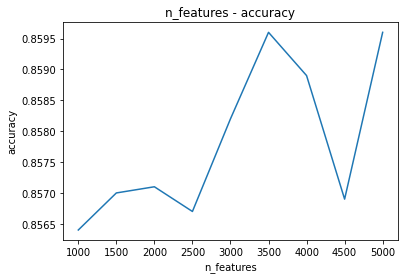

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(1000, 5001, 500), accs)
plt.xlabel('n_features')
plt.ylabel('accuracy')
plt.title('n_features - accuracy')
plt.show()

Качество от `0.8565` до `0.8595`. Это выглядит как плато, но отрисовать график начиная с маленькой размерности не успею. В целом, я уверен, что на плато качество выходит.

In [13]:
RFF = RFFPipeline(classifier='svm', use_PCA=True).fit(x_train_scaled, y_train)
accuracy_score(y_test, RFF.predict(x_test_scaled))

0.8696

`0.8572` было с логистической регрессией, при этом, обучалась она чуть больше минуты, SVM - 11 минут (679 секунд). Получается, что важно выбирать модель. Хотим качество побольше и готовы потратить 10 минут жизни - SVM. Иначе логистическая регрессия.

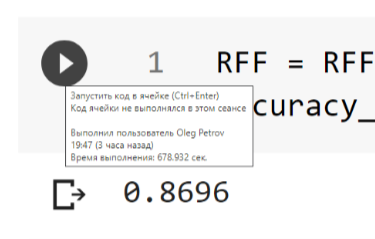